## ВШЭ, ФКН, Программа "Специалист по Data Science" (2021/2022)
## Курс "Прикладные задачи анализа данных - обработка звука"
### ДЗ: Анализ мел спектрограмм и классификация музыкальных жанров
##### Выполнил: Кирилл Н., 22.05.2022 г.

__Задание:__

[1. Построение мел спектрограммы](#Task1)

[2. Анализ мел спектрограмм](#Task2)
    
[3. Классификация музыкальных жанров](#Task3)

In [ ]:
!pip install torchaudio==0.10

In [3]:
from matplotlib import pyplot as plt
from IPython.display import Audio
from IPython import display

import torch
import torchaudio

import numpy as np

In [2]:
assert torch.__version__.startswith('1.1'), 'Please, install torch>=1.8'
assert torchaudio.__version__.startswith('0.1'), 'Please, install torchaudio>=0.8'

In [3]:
torchaudio.__version__

'0.11.0+cu113'

In [ ]:
!pip install PySoundFile

In [4]:
str(torchaudio.get_audio_backend())

'sox_io'

In [91]:
from pathlib import Path
import sys

try:
    import google.colab
    IN_COLAB = True
    
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    google.colab.drive.mount("/content/gdrive")
    ROOT = Path("/content/gdrive/My Drive/")
    assert ROOT.is_dir(), "Wrong path"
    sys.path.append(str(ROOT))
    
else:
    ROOT = Path(".")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **1. Построение мел спектрограммы [3 балла] <a id="Task1"></a>**

Загрузите wav файл и постройте спектрограмму. 

In [6]:
wav, sr = torchaudio.load(f'{ROOT}/female.wav')
print('wav.shape: {}'.format(wav.shape))
print('sr: {}'.format(sr))
print('Duration: {:.2f}s'.format(wav.shape[1]/sr))

wav.shape: torch.Size([1, 72960])
sr: 22050
Duration: 3.31s


In [7]:
Audio(wav, rate=sr)

In [8]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

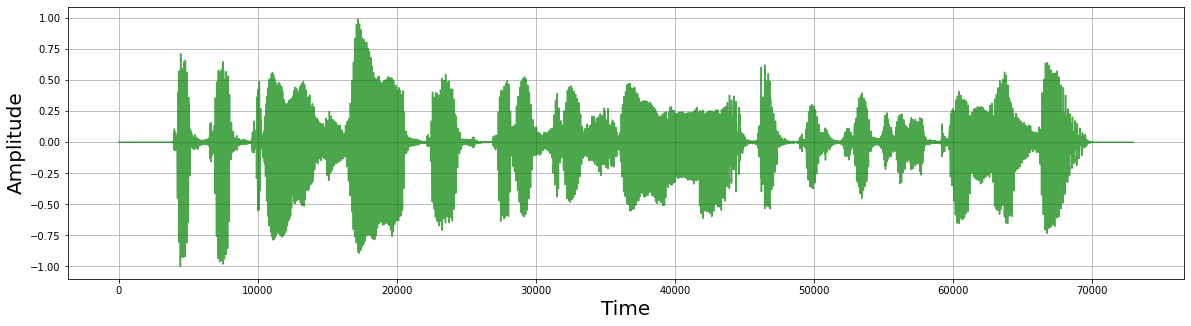

In [9]:
visualize_audio(wav)

Для построения спектра используйте следующие константы:

 - N_FFT - размер дискретного преобразования Фурье
 - HOP_LEN - длина шага между соседними окнами
 - WIN_LEN - размер окна
 - N_MELS - количество бинов при переводе спектрограммы в мел-шкалу 

In [83]:
N_FFT = 1024
HOP_LEN = 256
WIN_LEN = 1024
N_MELS = 80

In [11]:
spectrum = torch.fft.rfft(wav, n=N_FFT*5)
spectrogram = spectrum.abs().pow(2)

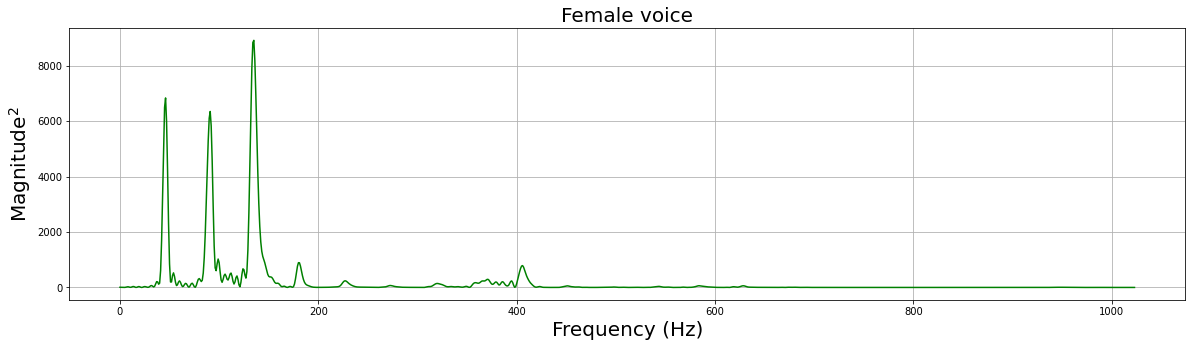

In [12]:
# Plot spectrogram
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze()[:N_FFT], c='green')
plt.grid()
plt.title('Female voice', size=20)
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()

Напишите функцию, принимающую волну, sample rate и возвращающую мел спектрограмму. 
Функция должна последовательно производить следующие действия:  [3 балла] 
 - Вычисление спектрограммы с дискретным преобразованием Фурье [``` torch.stft```](https://pytorch.org/docs/stable/generated/torch.stft.html) с предложенными выше параметрами и ```center=False``` - не добавляем нули для центрирования спектра и  ```onesided=True``` - берем только половину коэффициентов Фурье в силу их [симметричности](https://ru.dsplib.org/content/dft_prop/dft_prop.html) . 
 - взятие магнитуды спектра - квадрата нормы комплексных чисел полученных из ``` torch.stft``` 
 - Перевод в мел шкалу ```torchaudio.transforms.MelScale``` с параметрами ```n_mels=N_MELS``` и ```n_stft=N_FFT // 2 + 1``` в соответствии с размером спектрограммы.

In [84]:
def build_melspectrogram(wav, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS):
    ### YOUR CODE ### 
    spectrum = torch.stft(
        wav, 
        n_fft, 
        hop_len, 
        win_len, 
        window=torch.hann_window(win_len),
        center=False, 
        onesided=True, 
        return_complex=False)
    
    spectrogram = spectrum.norm(dim=-1).pow(2)

    mel_scaler = torchaudio.transforms.MelScale(
        n_mels=n_mels,
        sample_rate=22050,
        n_stft=n_fft//2 + 1
    )
    mel_spectrogram = mel_scaler(spectrogram)

    return mel_spectrogram

In [14]:
mel = build_melspectrogram(wav, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)

Для проверки используйте готовую реализацию из torchaudio:

In [15]:
featurizer = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=N_MELS,
    window_fn=torch.hann_window,
    center=False
)
mel2 = featurizer(wav)

In [16]:
torch.allclose(mel, mel2)

True

### **2. Анализ мел спектрограмм [5 баллов] <a id="Task2"></a>**

   - Визуализируйте мел спектрограмму с помощью ```plt.imshow```. Показательно ли изображение? Преобразуйте его так, чтобы значения стали в более узком диапазоне.
   - Визуализируйте мел спектрограмму с различными значениями ```hop_len``` и ```n_fft```. На что влияет параметр hop_len? Что будет, если уменьшить n_fft и win_len в 2 раза? Как вы думаете, почему? Насколько имеет смысл увеличивать num_mels? Почему? 
   - Сравните мел спектрограммы женского и мужского голоса ```female.wav``` и ```male.wav```. 
    Для адекватного сравнения приведите единые параметры цветовой схемы vmin, vmax (для этого посчитайте минимум и максимум мел спектрограмм).
   - Добавьте к аудио речи шум двух видов - белый шум ```noise.wav``` и последовательность нот ```notes.wav```. (Для этого нужно сложить обе волны, приведя их к одной длине.)
   - Визуализируйте мелспектрограммы аудио с добавленным шумом. Что можно сказать о наложенном шуме первого и второго вида? Почему они различны? 
    

In [92]:
wav, sr = torchaudio.load(f'{ROOT}/female.wav')

In [93]:
mel = build_melspectrogram(wav, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)

In [94]:
def visulaize_melspectrogram(mel, title=''):
  plt.figure(figsize=(20, 5))

  ## YOUR CODE
  plt.imshow(mel.squeeze().log())
  plt.colorbar()
  plt.title(title, size=20)
  plt.xlabel('Time', size=20)
  plt.ylabel('Mels', size=20)
  plt.show()

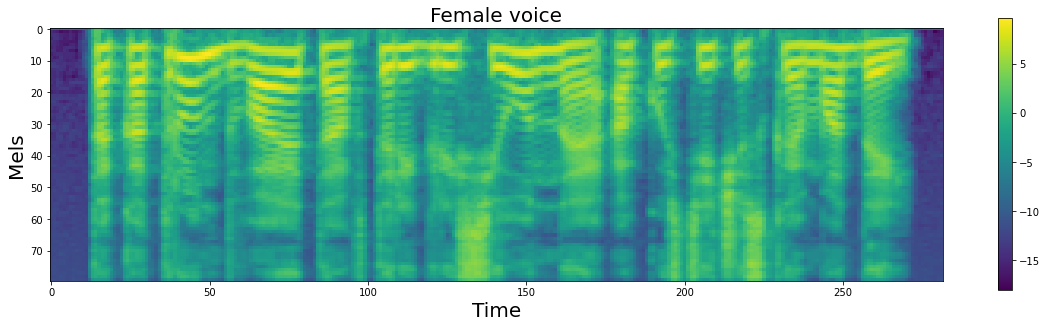

In [95]:
visulaize_melspectrogram(mel, 'Female voice')

**Увеличим длину шага между окнами hop_len**

In [21]:
mel2 = build_melspectrogram(wav, sr, n_fft=N_FFT, hop_len=HOP_LEN*3, win_len=WIN_LEN, n_mels=N_MELS)

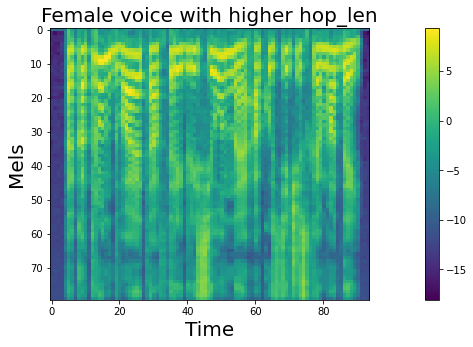

In [22]:
visulaize_melspectrogram(mel2, 'Female voice with higher hop_len')

Параметр hop_len влияет на расстояние между окнами и соответственно на объем расчетов при вычислении  дискретного преобразования Фурье. Также его увеличение при прочих равных условиях может привести к потери части информации, необходимой для обучения модели.

**Увеличим размер преобразования Фурье n_fft**

In [23]:
mel3 = build_melspectrogram(wav, sr, n_fft=N_FFT*10, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)

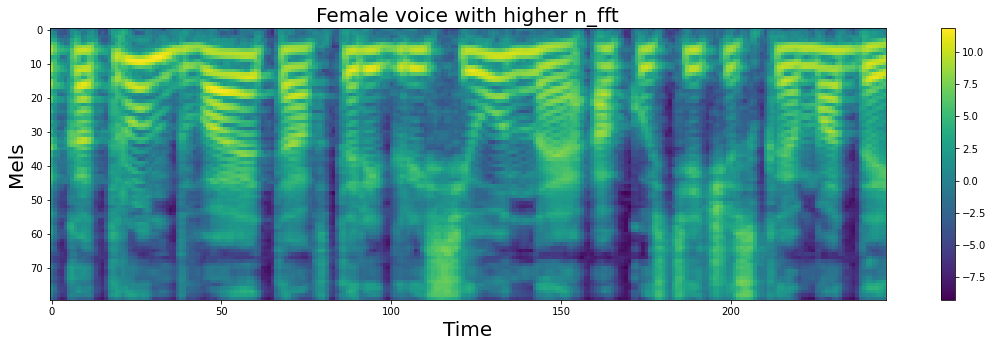

In [24]:
visulaize_melspectrogram(mel3, 'Female voice with higher n_fft')

При изменении n_fft в основном меняются диапазон получаемых магнитуд, а также объем необходимых вычислений (чем больше размер преобразования, тем больше операций нужно выполнить).

**Уменьшим размер преобразования Фурье n_fft и длину окна win_len**

In [25]:
mel4 = build_melspectrogram(wav, sr, n_fft=N_FFT//2, hop_len=HOP_LEN, win_len=WIN_LEN//2, n_mels=N_MELS)

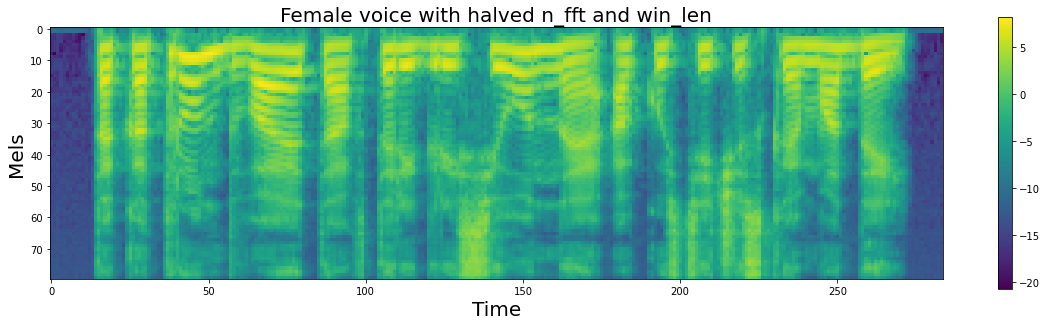

In [26]:
visulaize_melspectrogram(mel4, 'Female voice with halved n_fft and win_len')

В результате одновременного уменьшения n_fft и win_len спектрограмма практически не изменилась. Это можно объяснить тем, что вычисление спектра ДПФ дает похожий результат в обоих случаях, т.к. одновременно уменьшая n_fft и win_len, мы просто разбиваем соответствующие тензоры на 2 части.

**Увеличим количество бинов n_mels**

In [27]:
mel5 = build_melspectrogram(wav, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS*2)

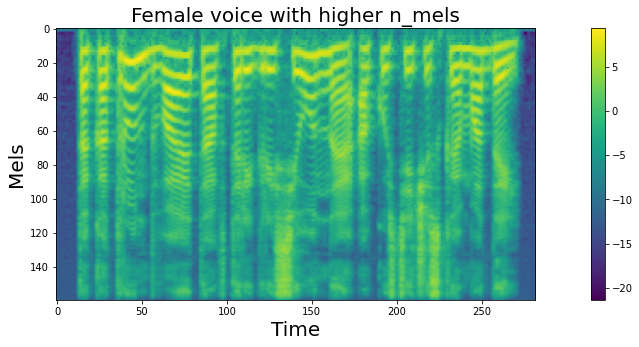

In [28]:
visulaize_melspectrogram(mel5, 'Female voice with higher n_mels')

Из следует из приведенного выше рисунка, изменение числа бинов num_mels можно заметить в основном на более низких частотах. При увеличении num_mels мы разбиваем частотный диапазон на большее кол-во интервалов, на каждом из которых к оконным преобазованиям Фурье применяются треугольные мел-фильтры, в результате чего на мел-шкале появляется больше заметных промежутков между максимумами магнитуд. 

Поскольку применение этих фильтров реализовано как перемножение матриц, то очевидно, что максимальное значение num_mels не должно превышать длины окна.

**Сравним мел спектрограммы женского и мужского голоса**

In [29]:
wav_male, sr_male = torchaudio.load(f'{ROOT}/male.wav')

In [30]:
Audio(wav_male, rate=sr_male)

In [31]:
mel_male = build_melspectrogram(wav_male, sr_male, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)


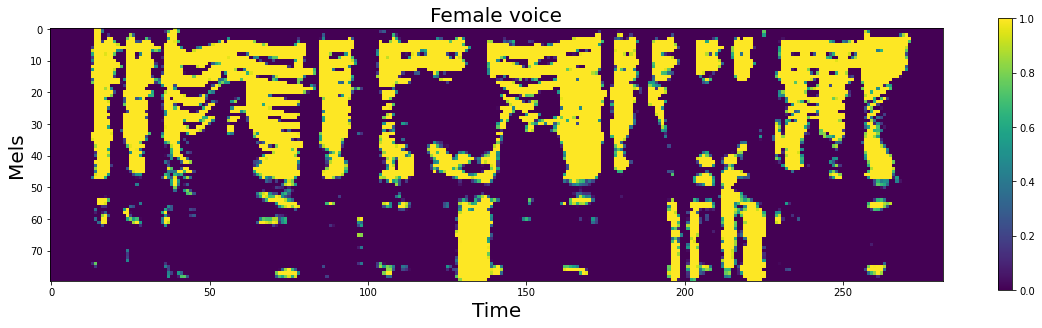

In [185]:
plt.figure(figsize=(20, 5))
plt.imshow(mel.squeeze().log(), vmin=0, vmax=1)
plt.colorbar()
plt.title('Female voice', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

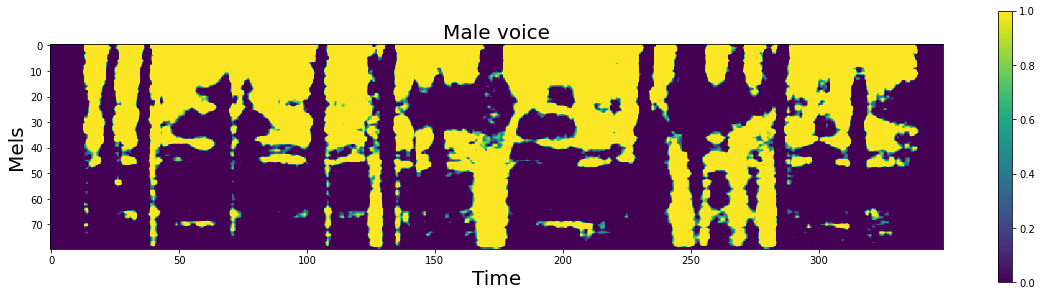

In [32]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_male.squeeze().log(), vmin=0, vmax=1)
plt.colorbar()
plt.title('Male voice', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

На мел спектрограммах женского и мужского голосов видно, что в последнем действительно преобладают более низкие частоты.

**Добавим к женскому голосу белый шум из noise.wav**

In [33]:
wav_noise, sr_noise = torchaudio.load(f'{ROOT}/noise.wav')

In [34]:
Audio(wav_noise, rate=sr_noise)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
wav_aug_1 = wav + wav_noise.mean(dim=0)[:wav.shape[1]]

In [36]:
mel_aug_1 = build_melspectrogram(wav_aug_1, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)

**Добавим к женскому голосу последовательность нот из notes.wav**

In [37]:
wav_notes, sr_notes = torchaudio.load(f'{ROOT}/notes.wav')

In [38]:
Audio(wav_notes, rate=sr_notes)

In [39]:
wav_aug_2 = wav + wav_notes.mean(dim=0)[:wav.shape[1]]

In [40]:
mel_aug_2 = build_melspectrogram(wav_aug_2, sr, n_fft=N_FFT, hop_len=HOP_LEN, win_len=WIN_LEN, n_mels=N_MELS)

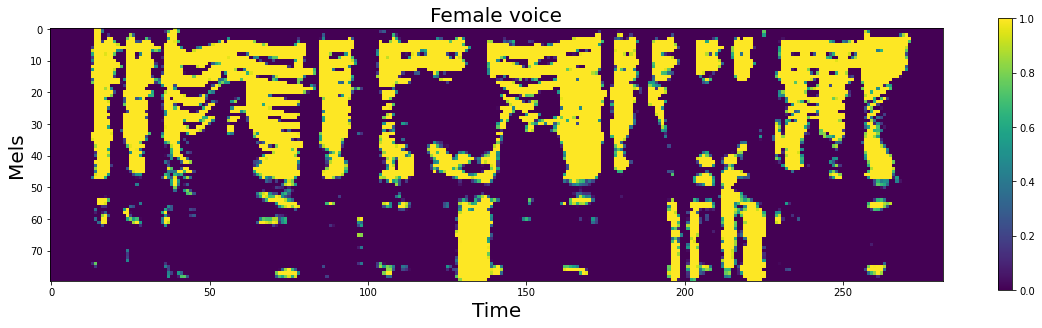

In [41]:
plt.figure(figsize=(20, 5))
plt.imshow(mel.squeeze().log(), vmin=0, vmax=1)
plt.colorbar()
plt.title('Female voice', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

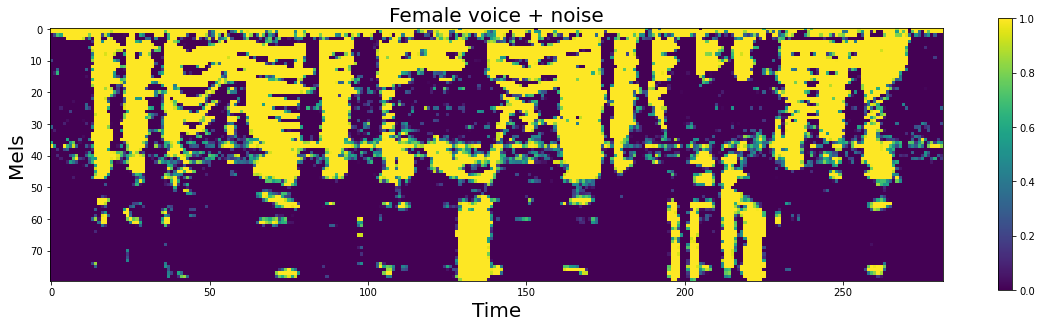

In [42]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_aug_1.squeeze().log(), vmin=0, vmax=1)
plt.colorbar()
plt.title('Female voice + noise', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

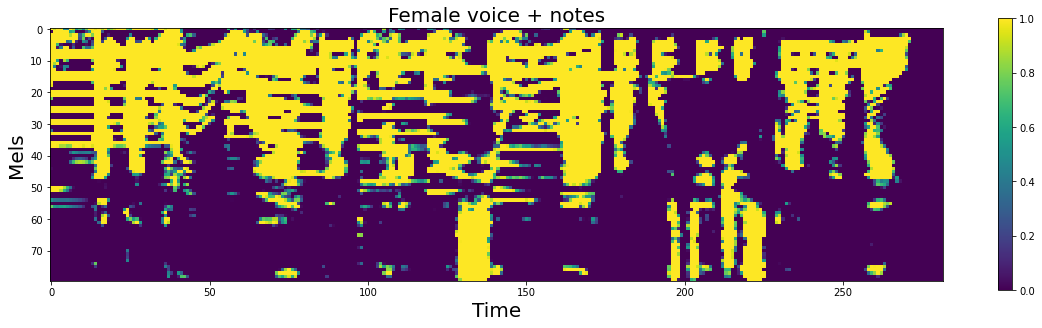

In [43]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_aug_2.squeeze().log(), vmin=0, vmax=1)
plt.colorbar()
plt.title('Female voice + notes', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

Таким образом, из приведенных выше рисунков следует, что ноты сильнее искажают исходную спектрограмму. Это можно объяснить тем, что спектр шума более равномерно распределен по всему диапазону частот по сравнению со спектром музыкального сигнала.

### **3. Классификация музыкальных жанров [12 баллов] <a id="Task3"></a>**

- В этом задании вам предлагается решить задачу классификации аудио по музыкальным жанрам.
  Вы можете взять за основу [решение](https://github.com/dmylzenova/speech_processing/blob/main/week02/Seminar_solved.ipynb) задачи AudioMnist, обучив нейронную сеть на мел-спектрограммах или [мел-кепстральных коэффициентах](https://pytorch.org/audio/stable/transforms.html#torchaudio.transforms.MFCC).
  Используйте для этого оригинальные wav файлы из `Data/genres_original/*/*.wav`.
  Но при желании вы можете этим не ограничиваться и решить задачу любым удобным для вас способом, построив решение на признаках извлеченных из датасета `Data/features_3_sec.csv` или `Data/features_30_sec.csv`
  
  Будьте внимательны при обработке данных и построении мел спектрограммы, обращая внимание на такие параметры как sample rate.
 - Разбейте данные, используя 90 % на трейн и 10% на валидацию.
 - Критерии оценки: достижение Accuracy score на валидации:
     - 0.3  - [5 баллов]
     - 0.4  - [6 баллов]
     - 0.5  - [7 баллов] 
     - 0.6 - [10 баллов] 
     - 0.7  - [12 баллов]
 - Проанализируйте ошибки модели, на каких классах ошибок больше? Как вы думаете, почему? [bonus points]

Скачайте данные:

In [45]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yqzjzzg30NTLwZIsBiAJEZxzvK9Dc4zw' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yqzjzzg30NTLwZIsBiAJEZxzvK9Dc4zw" -O music.zip && rm -rf /tmp/cookies.txt

--2022-05-22 15:31:27--  https://docs.google.com/uc?export=download&confirm=t&id=1yqzjzzg30NTLwZIsBiAJEZxzvK9Dc4zw
Resolving docs.google.com (docs.google.com)... 209.85.200.101, 209.85.200.102, 209.85.200.138, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/guk5el489vp2ggjof41a3nljhg5ougl9/1653233475000/15715835055052045372/*/1yqzjzzg30NTLwZIsBiAJEZxzvK9Dc4zw?e=download [following]
--2022-05-22 15:31:27--  https://doc-14-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/guk5el489vp2ggjof41a3nljhg5ougl9/1653233475000/15715835055052045372/*/1yqzjzzg30NTLwZIsBiAJEZxzvK9Dc4zw?e=download
Resolving doc-14-6g-docs.googleusercontent.com (doc-14-6g-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-14-6g-docs.googleusercontent.com (doc-14-6

Разархивируйте архив

In [46]:
!unzip music.zip

Archive:  music.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wav  
  inflating: Data/genres_origin

Удалите битый файл

In [47]:
!rm Data/genres_original/jazz/jazz.00054.wav

Данные хранятся в папках вида `Data/genres_original/hiphop/hiphop.00073.wav`
Создадим словарь вида {genre:id} для кодирования класса.

In [4]:
import pathlib
from collections import defaultdict
from typing import List, Tuple
from tqdm import tqdm
from itertools import islice

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

In [5]:
PATH_TO_DATA = "Data/"
genres = defaultdict(list)
paths = list(pathlib.Path(PATH_TO_DATA).rglob('*.wav'))
for path in paths:
    genre = path.as_posix().split("/")[-2]
    genres[genre].append(path)

In [6]:
genres_to_id = {genre: i for i, genre in enumerate(genres.keys())}

In [7]:
genres_to_id

{'blues': 3,
 'classical': 6,
 'country': 7,
 'disco': 9,
 'hiphop': 4,
 'jazz': 8,
 'metal': 1,
 'pop': 0,
 'reggae': 5,
 'rock': 2}

In [8]:
paths = list(pathlib.Path(PATH_TO_DATA).rglob('*.wav'))
len(paths)

999

In [9]:
wav, sr = torchaudio.load(paths[0])
print(wav.size())
print(sr)

torch.Size([1, 661504])
22050


In [10]:
SAMPLE_RATE = sr

In [11]:
class MusicGenresDataset(Dataset):
    SR = SAMPLE_RATE
        
    def __init__(self, path_to_data: str):
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('*.wav'))
    
    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()
        
        # Load wav
        wav, sr = torchaudio.load(path_to_wav)
        
        label = genres_to_id[path_to_wav.split('/')[-1].split('.')[0]]
        
        return wav, label
    
    def __len__(self):
        return len(self.paths)

In [12]:
dataset = MusicGenresDataset(PATH_TO_DATA)

In [13]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [58]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

Класс Collator объединяет аудиодорожки в один батч. Так как аудиофайлы могут иметь разную длину, то для того чтобы собрать их в батч, заполним недостающие данные нулями (сделаем паддинг). Для этого создадим тензор из нулей размера `[batch_size, max_wav_len]` и заполним его элементами батча.

In [14]:
class Collator:
    
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)
        
        for wav in wavs:
            lengths.append(wav.size(-1))
        
        max_len = max(lengths)
        batch_wavs = torch.zeros(len(batch), max_len)
        for i, (wav, length) in enumerate(zip(wavs, lengths)):
            batch_wavs[i, :length] = wav.squeeze()
            
        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()
        
        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
) 

validation_dataloader = DataLoader(
    validation_dataset, batch_size=64,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
) 

Класс Featurizer делает необходимый препроцессинг - считает мел спектрограмму, логарифмирует ее и считает длину спектрограммы.

In [24]:
N_FFT = 1024
WIN_LEN = N_FFT
HOP_LEN = 256
NUM_MELS = 128

In [17]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            win_length=WIN_LEN,
            hop_length=HOP_LEN,
            n_mels=NUM_MELS,
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [18]:
class MusicClassificationModel(nn.Module):
    
    def __init__(self, input_dim, hidden_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True)
        self.clf = nn.Linear(hidden_size, 10)
    
    def forward(self, input, length=None):
        output, _ = self.rnn(input.transpose(-1, -2))
        
        # Now we want to take the last hidden state of each instance in batch
        # BUT we don't want to take `padding` hidden state
        # We will use `torch.gather` and `length` to do that
        
        # learn more about gather
        # https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4
        
        last_hidden = torch.gather(
            output,
            dim=1,
            # substract 1 because index start from 0 (not 1 as length)
            index=length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
        )
        
        logits = self.clf(last_hidden.squeeze(dim=1))
        
        return logits

Зададим параметры модели и оптимизатора и функцию потерь

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = MusicClassificationModel(input_dim=NUM_MELS, hidden_size=128).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

Создадим класс для подсчета метрики

In [20]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [70]:
storage = defaultdict(list)
num_epoch = 10

In [65]:
# Структура данных для анализа точности в разрезе каждого жанра для последней эпохи
genres_valid_acc = []
for genre in genres:
    genres_valid_acc.append(AverageMeter())

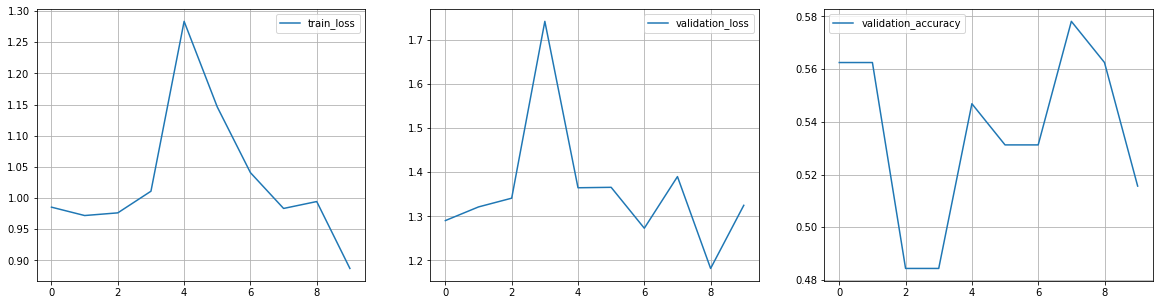

In [71]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()
    print(f"Epoch {epoch} out of {num_epoch}")

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # Compute mel spectrogram
        mel, mel_length = featurizer(wav, length)

        # feed model
        output = model(mel, mel_length)

        # compute loss
        loss = criterion(output, label)

        # zero out previously computed gradients
        optimizer.zero_grad()

        # compute gradients
        loss.backward()
    
        # update weights
        optimizer.step()

        # update metrics
        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()
           
    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # in inference mode we don't need to compute gradients
        # so we use `no_grad()` context manager to speed up inference
        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
        
        # compute accuracy
        matches = (output.argmax(dim=-1) == label).float().mean()
        
        if epoch == num_epoch-1:
            for genre in genres:
                id = genres_to_id[genre]
                genre_matches = (output.argmax(dim=-1)[(label==id)] == id).float().mean()
                genres_valid_acc[id].update(genre_matches.item())

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())

    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    display.clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()      
        axes[i].legend()

    plt.show()

In [102]:
print('Accuracy on the last epoch #{}: {:.2f}'.format(epoch, validation_accuracy_meter.avg))

Accuracy on the last epoch #9: 0.52


**Анализ ошибок на отдельных классах**

In [103]:
print('Accuracies per genres:\n')
for genre in genres:
    id = genres_to_id[genre]
    print('{}: {:.2f}'.format(genre, genres_valid_acc[id].avg))

Accuracies per genres:

pop: 0.91
metal: 0.94
rock: 0.00
blues: 0.45
hiphop: 0.40
reggae: 0.50
classical: 0.80
country: 0.20
jazz: 0.19
disco: 0.17


Из приведенного выше списка следует, что наименьшая точность у жанров rock и disco. Это можно объяснить тем, что они имеют много общих черт с другими жанрами, из-за чего их спектрограммы обладают небольшим количеством характерных особенностей.